In [217]:
import pandas as pd
import bagpy
import pickle
import pathlib
import pinocchio as pin
import hppfcl as fcl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as m_patches
from matplotlib.collections import PatchCollection
import seaborn as sns

from panda_loader import load_panda

### Convert ROS bag file to pickle

In [218]:
def extract_data(in_file: str, out_file: str) -> pd.DataFrame:
    bag = bagpy.bagreader(in_file)
    topic_data = []
    for topic in bag.topics:
        df = pd.read_csv(bag.message_by_topic(topic))
        topic_data.append(df[df.columns.drop(list(df.filter(regex="head")))])

    with open(out_file, "wb") as handle:
        pickle.dump(topic_data, handle, protocol=pickle.HIGHEST_PROTOCOL)


bag_path_col_pair = pathlib.Path().resolve().parent / "bags"
pkl_path = pathlib.Path().resolve().parent / "pickle"
pathlib.Path(pkl_path).mkdir(parents=True, exist_ok=True)
for file in bag_path_col_pair.glob("*.bag"):
    extract_data(file.as_posix(), pkl_path / file.with_suffix(".pkl").name)

[INFO]  Data folder /home/krzysiek/Documents/Programming/laas/panda_torque_mpc/bags/2024-01-23-15-55-41_2_col already exists. Not creating.
[INFO]  Data folder /home/krzysiek/Documents/Programming/laas/panda_torque_mpc/bags/2024-01-23-15-58-24_1_col already exists. Not creating.
[INFO]  Data folder /home/krzysiek/Documents/Programming/laas/panda_torque_mpc/bags/2024-01-23-15-48-53_4_col already exists. Not creating.
[INFO]  Data folder /home/krzysiek/Documents/Programming/laas/panda_torque_mpc/bags/2024-01-23-15-37-12_5_col already exists. Not creating.
[INFO]  Data folder /home/krzysiek/Documents/Programming/laas/panda_torque_mpc/bags/2024-01-23-22-50-38 already exists. Not creating.
[INFO]  Data folder /home/krzysiek/Documents/Programming/laas/panda_torque_mpc/bags/2024-01-23-15-53-03_3_col already exists. Not creating.


In [219]:
DEFAULT_FONT_SIZE = 35
DEFAULT_AXIS_FONT_SIZE = DEFAULT_FONT_SIZE
DEFAULT_LINE_WIDTH = 4  # 13
DEFAULT_MARKER_SIZE = 4
DEFAULT_FONT_FAMILY = "sans-serif"
DEFAULT_FONT_SERIF = [
    "Times New Roman",
    "Times",
    "Bitstream Vera Serif",
    "DejaVu Serif",
    "New Century Schoolbook",
    "Century Schoolbook L",
    "Utopia",
    "ITC Bookman",
    "Bookman",
    "Nimbus Roman No9 L",
    "Palatino",
    "Charter",
    "serif",
]
DEFAULT_FIGURE_FACE_COLOR = "white"  # figure facecolor; 0.75 is scalar gray
DEFAULT_LEGEND_FONT_SIZE = 30  # DEFAULT_FONT_SIZE
DEFAULT_AXES_LABEL_SIZE = DEFAULT_FONT_SIZE  # fontsize of the x any y labels
DEFAULT_TEXT_USE_TEX = False
LINE_ALPHA = 0.9
SAVE_FIGURES = False
FILE_EXTENSIONS = ["pdf", "png"]  # ,'eps']
FIGURES_DPI = 150
SHOW_FIGURES = False
FIGURE_PATH = "./plot/"

mpl.rcdefaults()
mpl.rcParams["lines.linewidth"] = DEFAULT_LINE_WIDTH
mpl.rcParams["lines.markersize"] = DEFAULT_MARKER_SIZE
mpl.rcParams["patch.linewidth"] = 1
mpl.rcParams["font.family"] = DEFAULT_FONT_FAMILY
mpl.rcParams["font.size"] = DEFAULT_FONT_SIZE
mpl.rcParams["font.serif"] = DEFAULT_FONT_SERIF
mpl.rcParams["text.usetex"] = DEFAULT_TEXT_USE_TEX
mpl.rcParams["axes.labelsize"] = DEFAULT_AXES_LABEL_SIZE
mpl.rcParams["axes.grid"] = True
mpl.rcParams["legend.fontsize"] = DEFAULT_LEGEND_FONT_SIZE
# opacity of of legend frame
mpl.rcParams["legend.framealpha"] = 1.0
mpl.rcParams["figure.facecolor"] = DEFAULT_FIGURE_FACE_COLOR
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
scale = 1.0
mpl.rcParams["figure.figsize"] = 30 * scale, 10 * scale  # 23, 18  # 12, 9
line_styles = 10 * ["b", "g", "r", "c", "y", "k", "m"]

In [220]:
pkl_path = pathlib.Path().resolve().parent / "pickle"
b = {}
for file in pkl_path.glob("*.pkl"):
    with open(file, "rb") as handle:
        b[file.name] = pickle.load(handle)

In [221]:
import re

time_df_cp = pd.DataFrame(columns=["Computation Time", "Number of Collision Pairs"])
for name, data in b.items():
    # Very dirty regex...
    collision_name = re.findall("[0-9]_col", name)
    if len(collision_name) > 0:
        ncp = int(collision_name[0].strip("_col"))
        time_df_local = pd.DataFrame(
            columns=["Computation Time", "Number of Collision Pairs"]
        )
        time_df_local["Computation Time"] = data[2]["data.nsecs"] * 1e-6
        time_df_local["Number of Collision Pairs"] = ncp
        time_df_cp = pd.concat([time_df_cp, time_df_local])

/tmp/ipykernel_16474/361238303.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  time_df_cp = pd.concat([time_df_cp, time_df_local])


https://seaborn.pydata.org/examples/grouped_boxplot.html this one is nice


/home/krzysiek/miniconda3/envs/analyze/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


Text(0, 0.5, 'Computation Time (ms)')

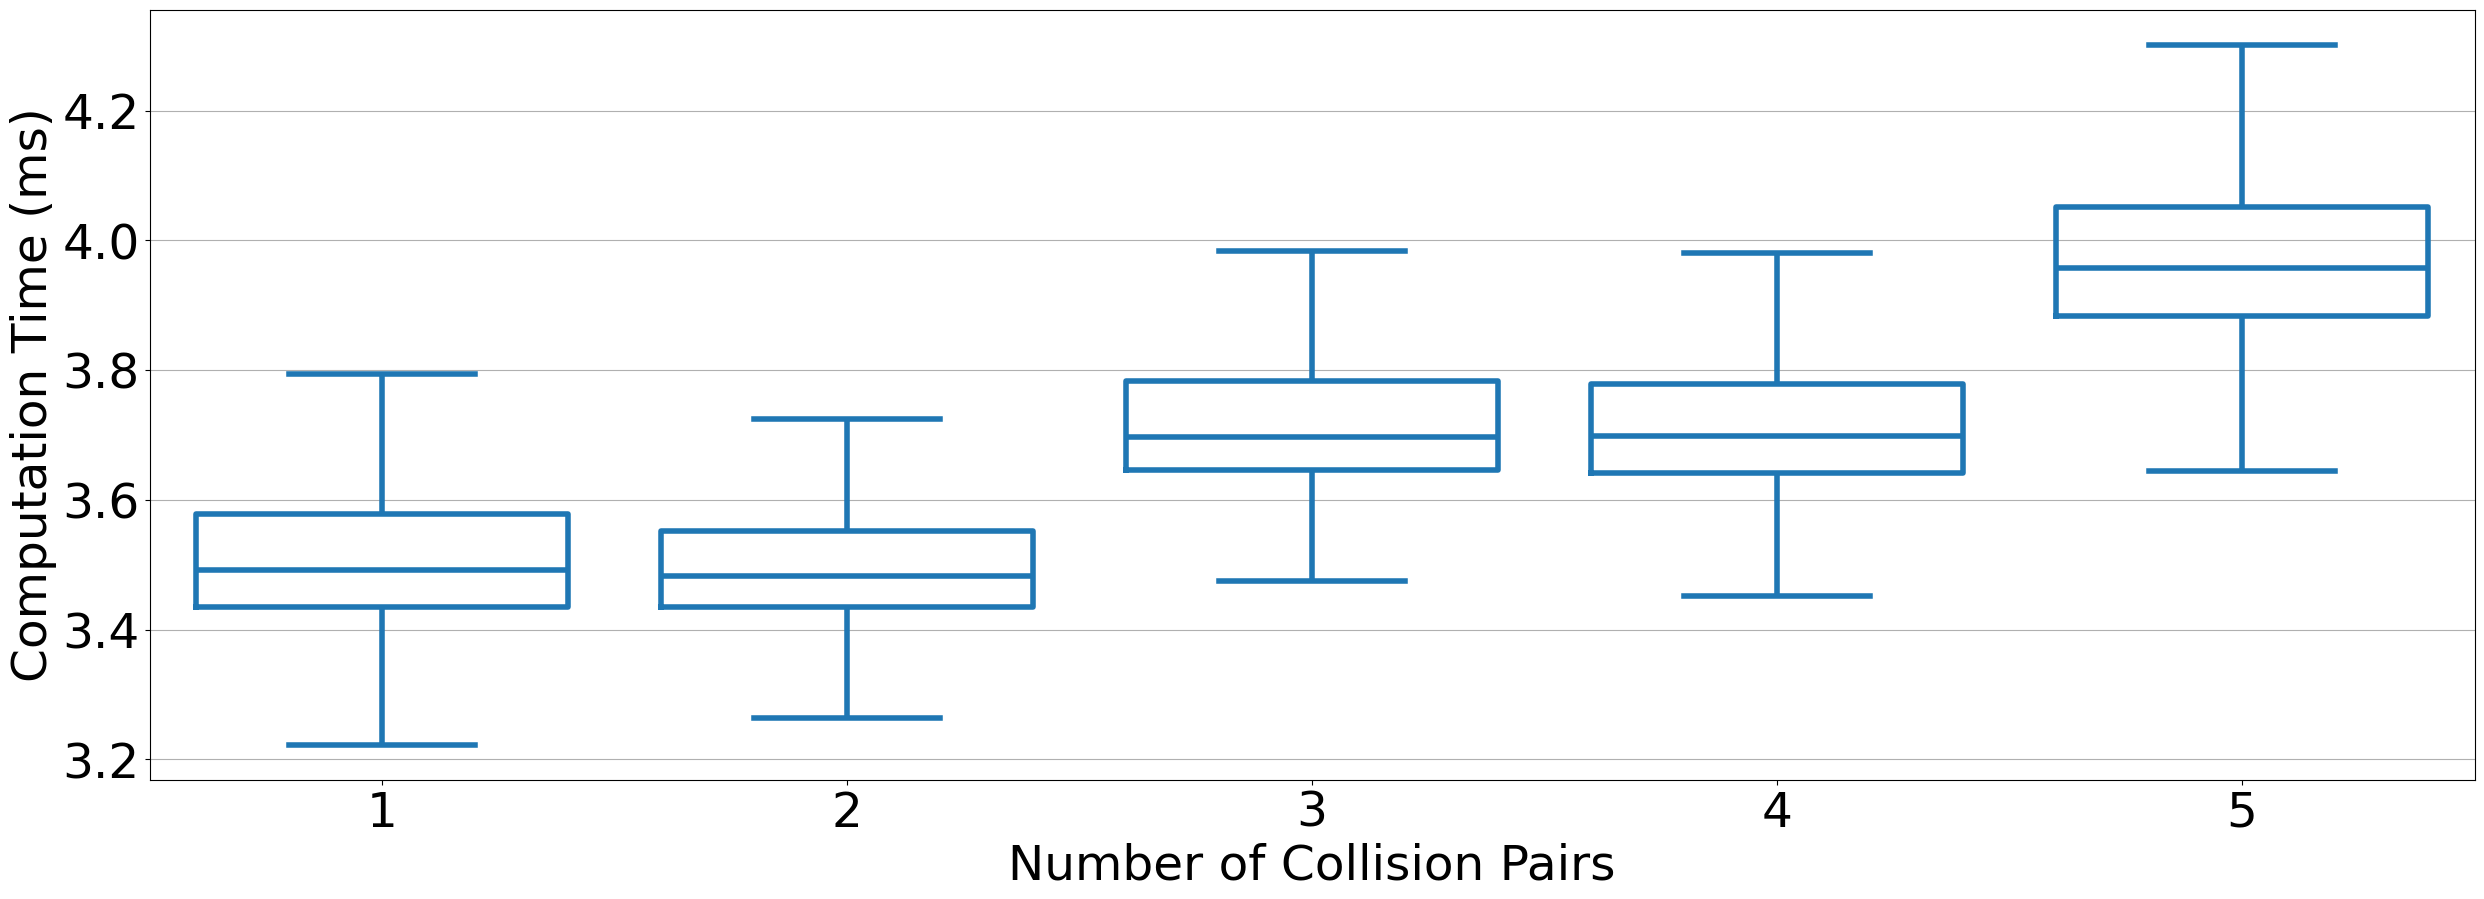

In [222]:
ax = sns.boxplot(
    time_df_cp.loc[(time_df_cp["Computation Time"] > 2.5)],
    # time_df_cp,
    x="Number of Collision Pairs",
    y="Computation Time",
    showfliers=False,
    fill=False,
)
# ax.set_ylim((0.0, 7.5))
plt.xlabel("Number of Collision Pairs")
plt.ylabel("Computation Time (ms)")

/home/krzysiek/miniconda3/envs/analyze/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/krzysiek/miniconda3/envs/analyze/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/krzysiek/miniconda3/envs/analyze/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

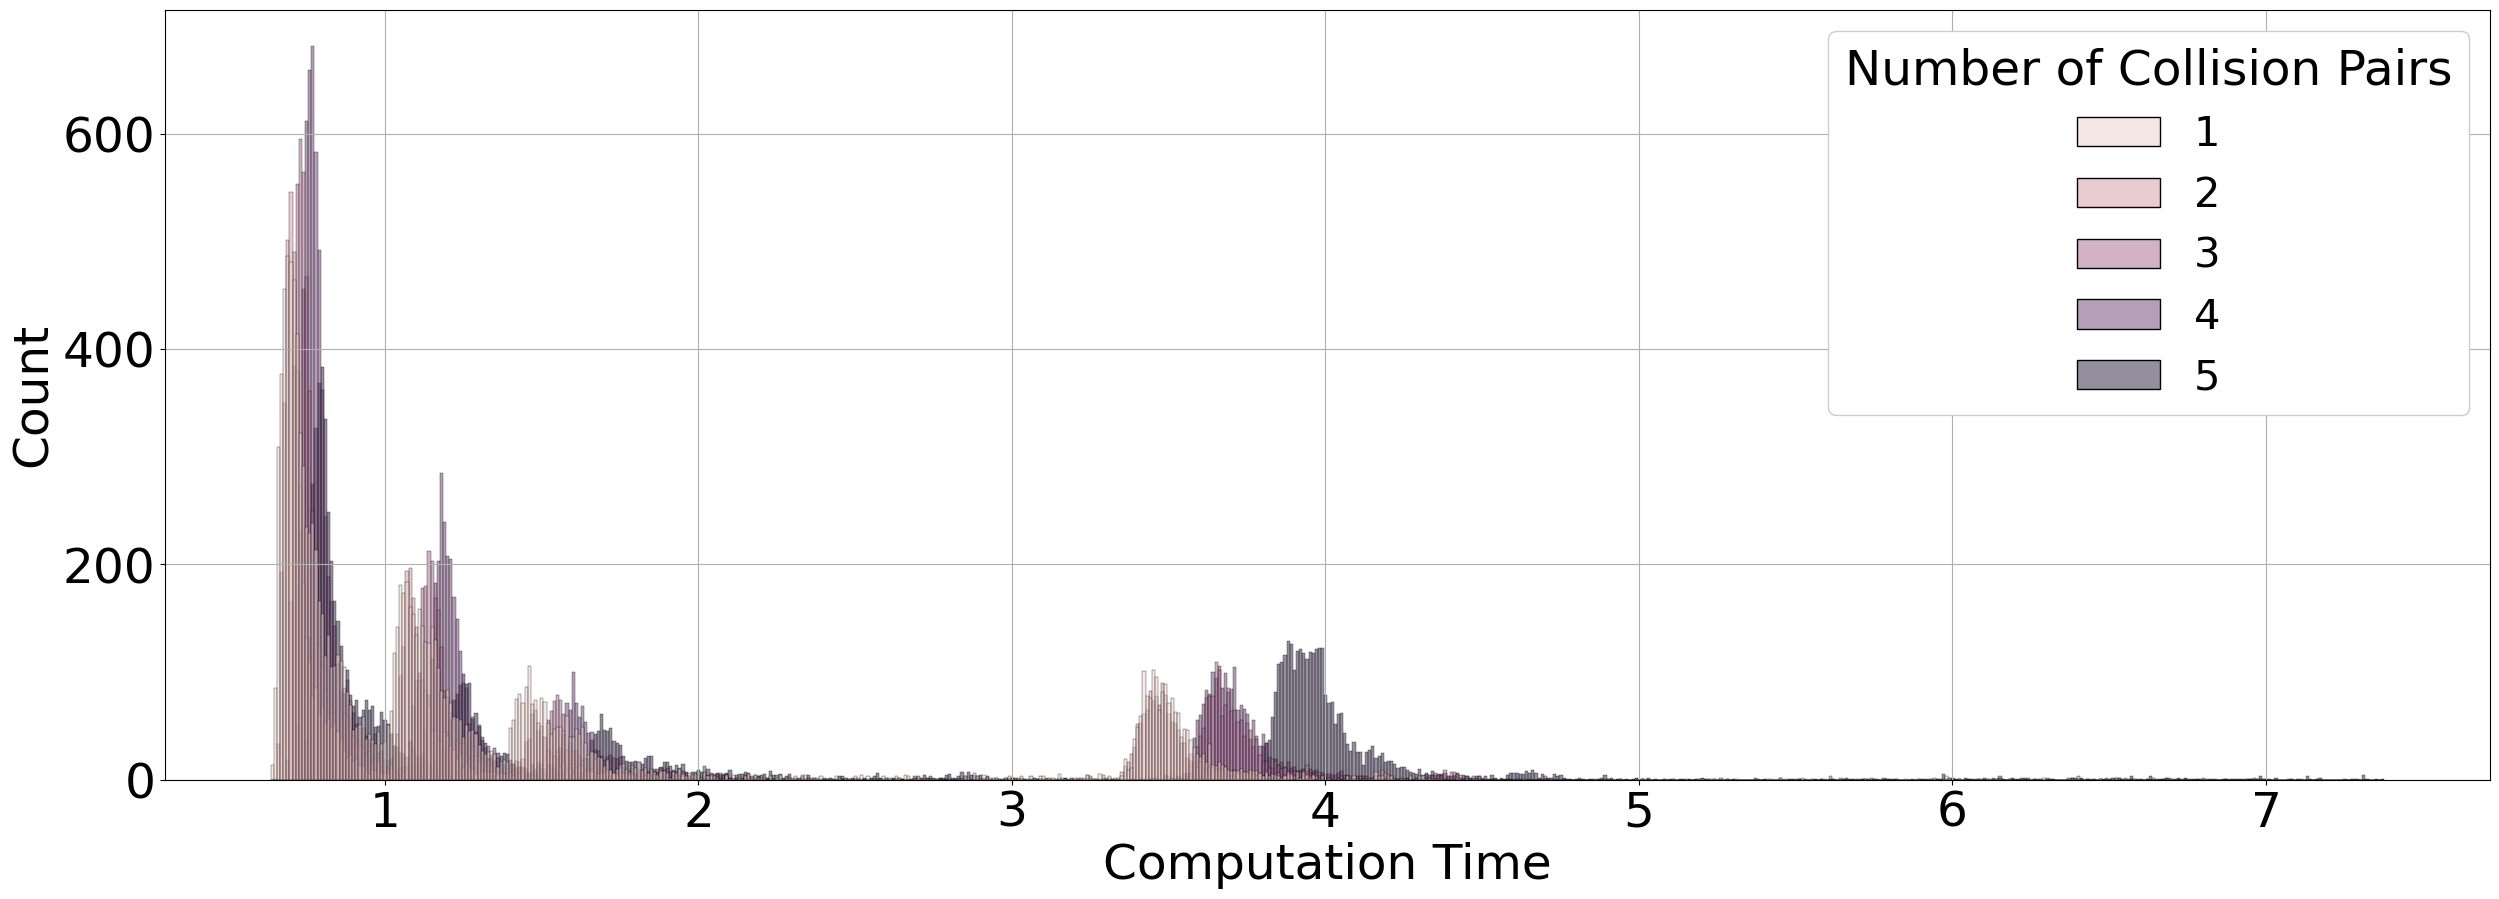

In [223]:
ax = sns.histplot(
    time_df_cp, x="Computation Time", hue="Number of Collision Pairs", binwidth=0.01
)
# ax.set_xticks(np.arange(0, 7, 0.1))

In [224]:
stats_df = pd.DataFrame()
stats_df["Maximum"] = time_df_cp.groupby("Number of Collision Pairs").max()
lower = time_df_cp.loc[(time_df_cp["Computation Time"] < 1.0)]
lower = lower.groupby("Number of Collision Pairs")
stats_df["Lower bound Min"] = lower.mean()
stats_df["Lower bound std"] = lower.std()

upper = time_df_cp.loc[
    (time_df_cp["Computation Time"] > 3.2) & (time_df_cp["Computation Time"] < 4.5)
]
upper = upper.groupby("Number of Collision Pairs")
stats_df["Upper Bound Min"] = upper.mean()
stats_df["Upper Bound std"] = upper.std()

stats_df

,Maximum,Lower bound Min,Lower bound std,Upper Bound Min,Upper Bound std
Number of Collision Pairs,,,,,
1,6.581389,0.751991,0.079356,3.544178,0.176984
2,6.470491,0.731835,0.059834,3.530385,0.168753
3,7.114968,0.764661,0.059401,3.739509,0.174627
4,6.954970,0.793757,0.055175,3.729598,0.148542
5,7.377244,0.834597,0.061406,3.971058,0.130597


In [225]:
print(stats_df.to_latex(header=True, float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
 & Maximum & Lower bound Min & Lower bound std & Upper Bound Min & Upper Bound std \\
Number of Collision Pairs &  &  &  &  &  \\
\midrule
1 & 6.58 & 0.75 & 0.08 & 3.54 & 0.18 \\
2 & 6.47 & 0.73 & 0.06 & 3.53 & 0.17 \\
3 & 7.11 & 0.76 & 0.06 & 3.74 & 0.17 \\
4 & 6.95 & 0.79 & 0.06 & 3.73 & 0.15 \\
5 & 7.38 & 0.83 & 0.06 & 3.97 & 0.13 \\
\bottomrule
\end{tabular}



### Distance to obstacle

In [226]:
rmodel, cmodel = load_panda()

In [227]:
def compute_minimal_distances_between_collision_pairs(q):
    # Creates data models
    rdata = rmodel.createData()
    cdata = cmodel.createData()

    # Updating the models
    pin.framesForwardKinematics(rmodel, rdata, q)
    pin.updateGeometryPlacements(rmodel, rdata, cmodel, cdata, q)

    # HPPFCL Queries
    req = fcl.DistanceRequest()
    res = fcl.DistanceResult()

    # List storing all the distances, from the first collision pair to the last in the order of addition in the collision model
    list_dist = []
    # Going through all the collision pairs
    for col_pair in cmodel.collisionPairs:
        # Geometry objects ID in the collision model
        pair1_id = col_pair.first
        pair2_id = col_pair.second

        dist = fcl.distance(
            cmodel.geometryObjects[pair1_id].geometry,
            cdata.oMg[pair1_id],
            cmodel.geometryObjects[pair2_id].geometry,
            cdata.oMg[pair2_id],
            req,
            res,
        )
        list_dist.append(dist)
    return list_dist

In [228]:
df_curr = b["2024-01-23-15-37-12_5_col.pkl"]
q_arr = df_curr[3]["joint_state.position"]
dist_array = np.zeros((q_arr.shape[0], 4))
for i in range(dist_array.shape[0]):
    dist_array[i] = compute_minimal_distances_between_collision_pairs(
        np.array(eval(q_arr[i]))
    )

In [229]:
# Convert distance to dataframe
dist_df = pd.DataFrame(
    columns=["Time", "Right finger", "Left finger", "Link 7 part 1", "Link 7 part 2"]
)
dist_df["Time"] = df_curr[3]["Time"] - df_curr[3]["Time"][0]
dist_df["Right finger"] = dist_array[:, 0]
dist_df["Left finger"] = dist_array[:, 1]
dist_df["Link 7 part 1"] = dist_array[:, 2]
dist_df["Link 7 part 2"] = dist_array[:, 3]
dist_df["Lower bound"] = np.full((dist_array.shape[0]), 0.1)
time_df = df_curr[2]
time_df["Time"] -= time_df["Time"][0]
time_df["data.nsecs"] = time_df["data.nsecs"].copy() * 1e-6

In [238]:
changes_df = df_curr[0][["Time", "pose.position.y"]]
changes_df["Time"] -= changes_df["Time"][0]
changes_df = changes_df.loc[changes_df["pose.position.y"].diff() > 0]
changes_df.head(5)

/tmp/ipykernel_16474/1460104052.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  changes_df["Time"] -= changes_df["Time"][0]


,Time,pose.position.y
151,2.511,0.35
451,7.511,0.35
751,12.511,0.35
1051,17.511,0.35
1351,22.511,0.35


In [239]:
# Pick moment in the time
t_min = 1.0
t_max = 11.0

dist_df_cropped = dist_df.loc[
    (dist_df["Time"] > t_min) & (dist_df["Time"] < t_max)
].reset_index()
time_df_cropped = time_df.loc[
    (time_df["Time"] > t_min) & (time_df["Time"] < t_max)
].reset_index()
changes_df_cropped = changes_df.loc[
    (changes_df["Time"] > t_min) & (changes_df["Time"] < t_max)
].reset_index()
dist_df_cropped["Time"] -= t_min
time_df_cropped["Time"] -= t_min
changes_df_cropped["Time"] -= t_min


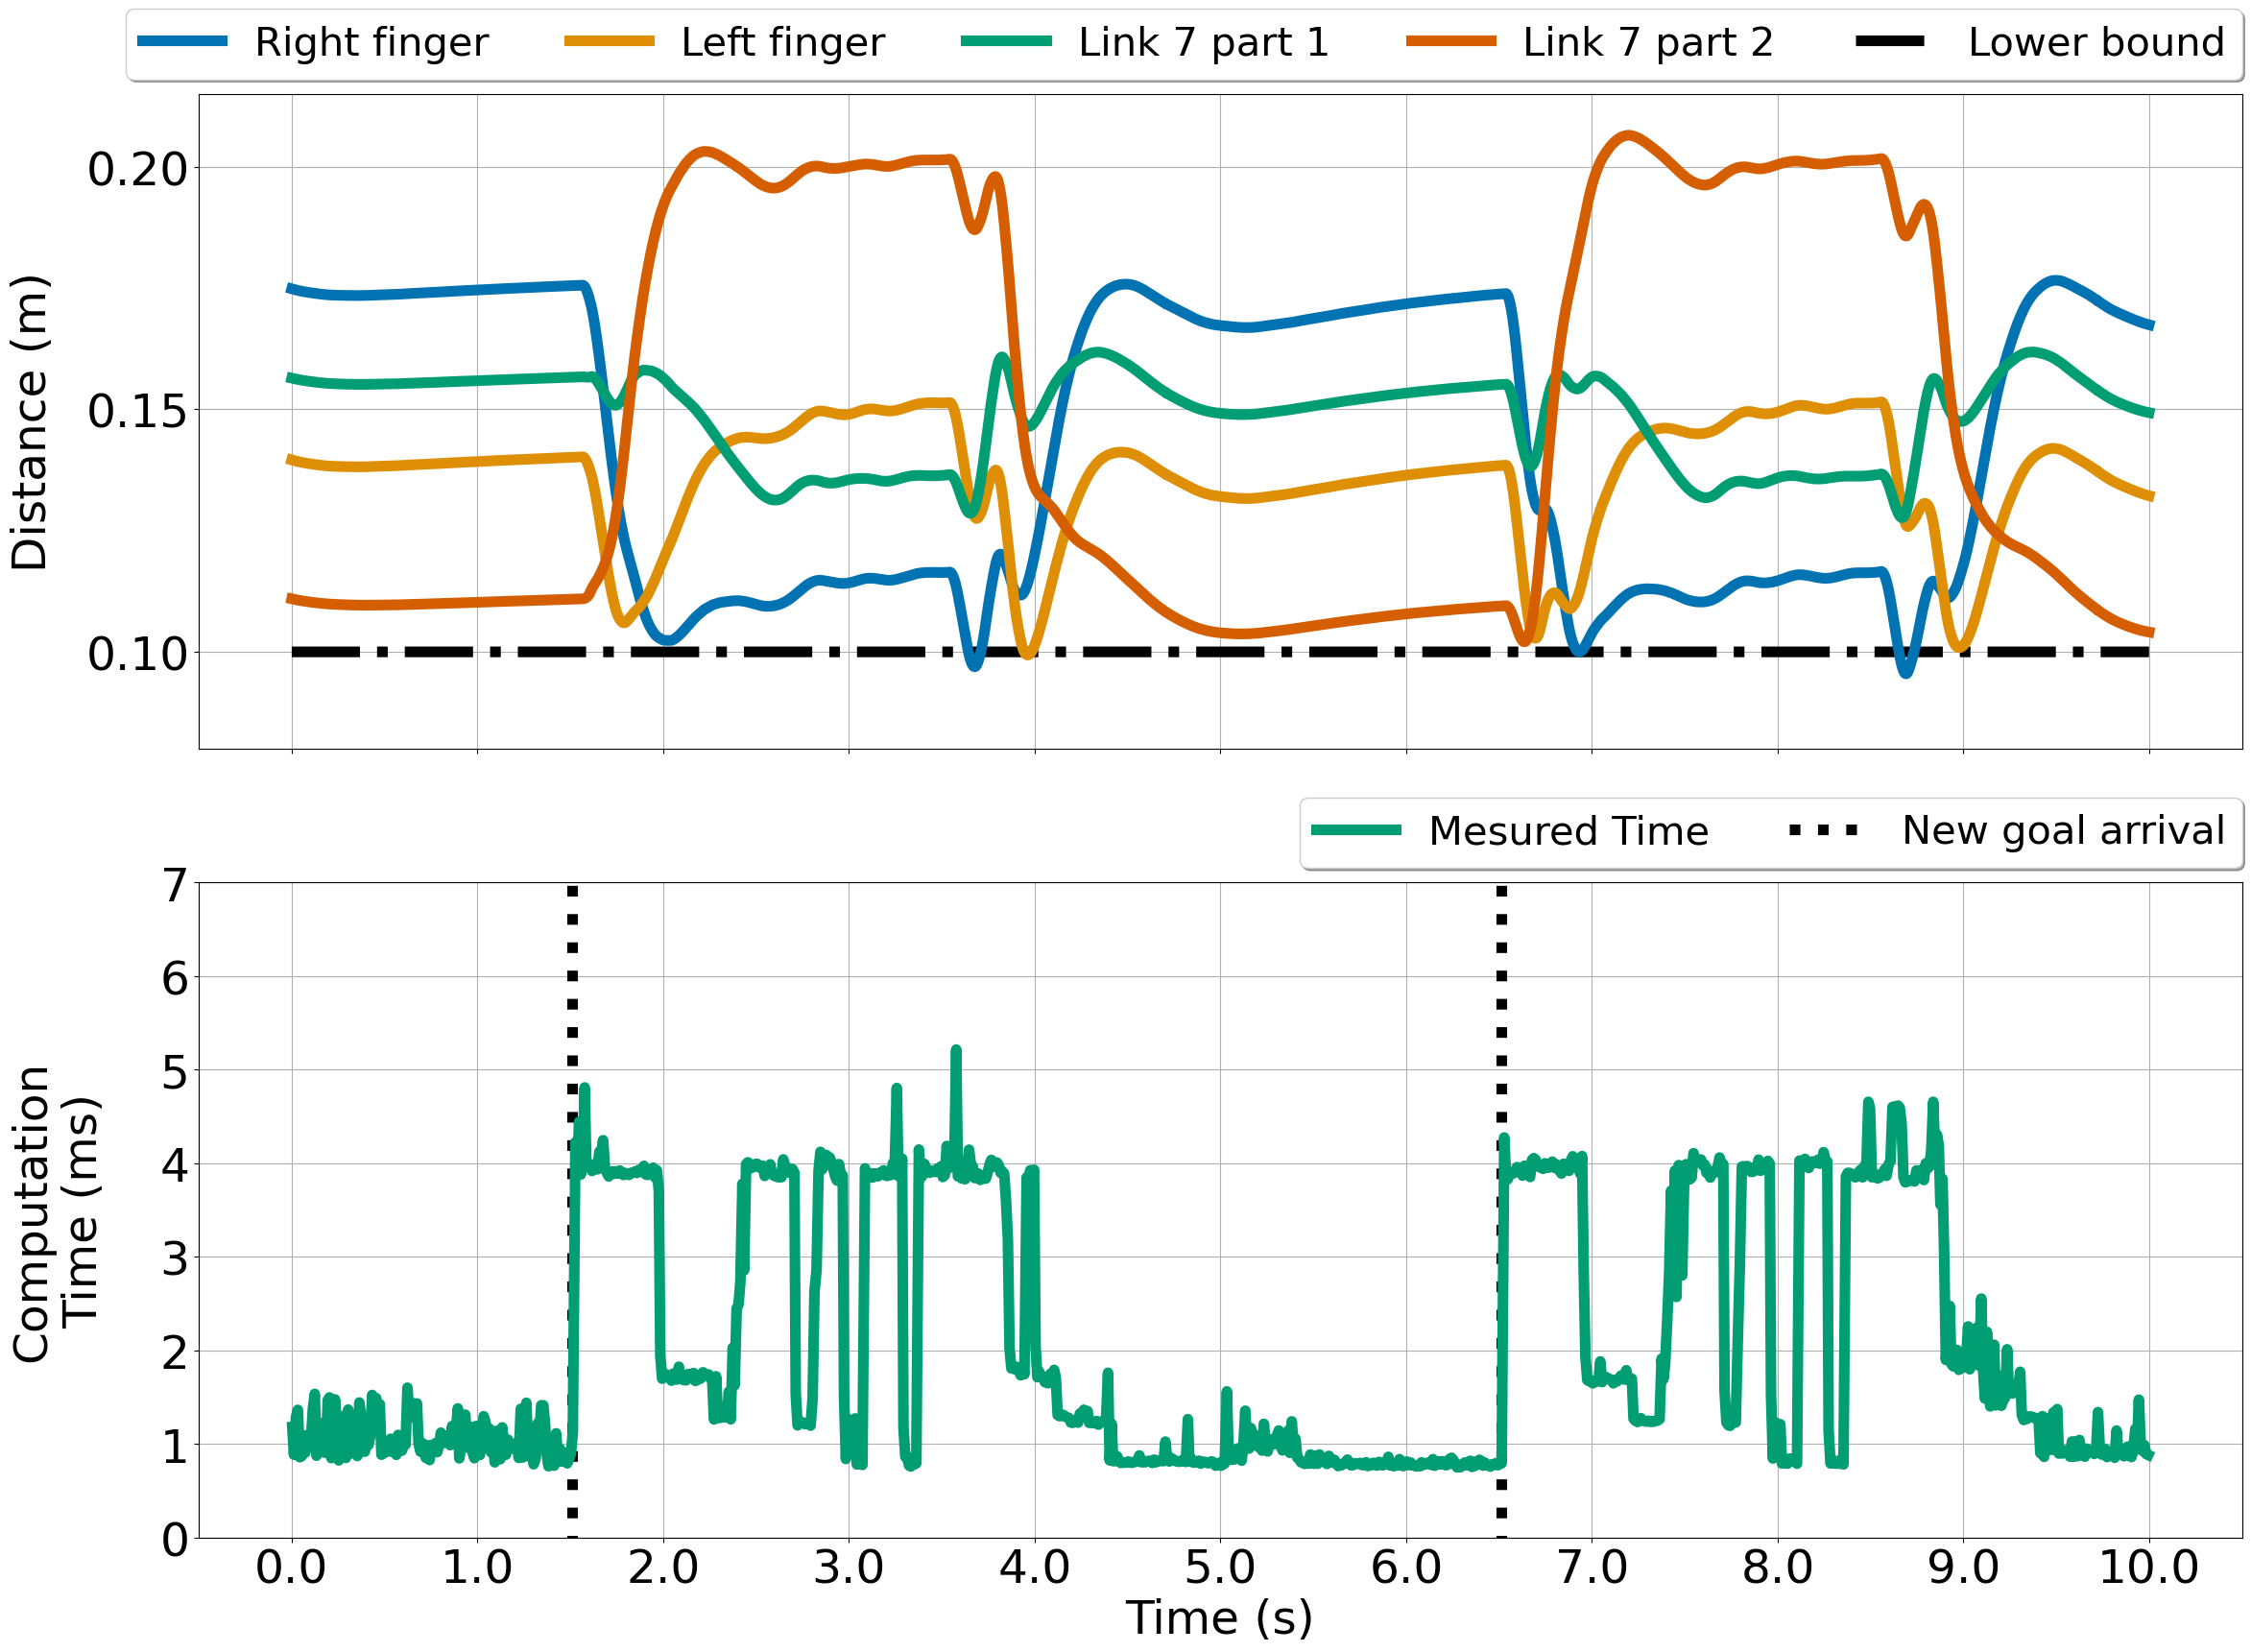

In [242]:
from matplotlib.transforms import Bbox

fig, axs = plt.subplots(nrows=2, sharex="col", figsize=(25, 18))

sns.set_palette("colorblind")

collision_pairs = {
    "Right finger": (0, (3, 1, 1, 1)),
    "Left finger": (0, (5, 1)),
    "Link 7 part 1": (0, (1, 1)),
    "Link 7 part 2": (0, (3, 1, 1, 1, 1, 1)),
}

sns.lineplot(
    dist_df_cropped,
    x="Time",
    y="Lower bound",
    ax=axs[0],
    label="Lower bound",
    color="#000000",
    linewidth=8.0,
    linestyle="-.",
)

for cp, line in collision_pairs.items():
    sns.lineplot(
        dist_df_cropped,
        x="Time",
        y=cp,
        ax=axs[0],
        label=cp,
        linewidth=8.0,
        # linestyle=line
    )

ts = np.array(changes_df_cropped["Time"])
axs[1].vlines(ts, -1, 7, linestyles=":", color="k", linewidth=8.0, label="New goal arrival")

sns.lineplot(
    time_df_cropped,
    x="Time",
    y="data.nsecs",
    ax=axs[1],
    color="C2",
    linewidth=8.0,
    label="Mesured Time"
)

axs[1].set_ylim([0, 7])

# axs[0].set_xlim([0, dist_df_cropped.tail(1)["Time"].item()])
axs[0].set_ylim([0.08, 0.215])
axs[0].set_yticks([0.1, 0.15, 0.2])


# plt.legend()
axs[0].set_ylabel("Distance (m)")
axs[1].set_ylabel("Computation\nTime (ms)")
axs[1].set_xlabel("Time (s)")

handles, labels = axs[0].get_legend_handles_labels()
order = [1, 2, 3, 4, 0]
axs[0].legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    fancybox=True,
    # framealpha=0.0,
    loc="upper right",
    bbox_to_anchor=(1.0, 1.13),
    shadow=True,
    borderaxespad=0,
    ncol=5,
)

handles, labels = axs[1].get_legend_handles_labels()
order = [1, 0]
axs[1].legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    fancybox=True,
    # framealpha=0.0,
    loc="upper right",
    bbox_to_anchor=(1.0, 1.13),
    shadow=True,
    borderaxespad=0,
    ncol=2,
)

axs[0].get_yaxis().set_label_coords(-0.07, 0.5)
axs[1].get_yaxis().set_label_coords(-0.045, 0.5)
axs[1].set_xticks(np.arange(0,10.5,1.0))
axs[1].set_xticklabels(np.arange(0,10.5,1.0))

plt.tight_layout()
plt.savefig(
    "distance_to_time.svg",
    format="svg",
    pad_inches=1.5,
    bbox_inches=Bbox([[0.5, 0], [26.5, 18]]),
)
plt.show()

In [233]:
def compute_end_effector_position(q):
    # Creates data models
    rdata = rmodel.createData()
    cdata = cmodel.createData()

    # Updating the models
    pin.framesForwardKinematics(rmodel, rdata, q)
    pin.updateGeometryPlacements(rmodel, rdata, cmodel, cdata, q)

    return rdata.oMf[rmodel.getFrameId("panda2_hand")].translation

df_curr_pose_collision = b["2024-01-23-15-37-12_5_col.pkl"]
df_curr_pose_no_collision = b["2024-01-23-22-50-38.pkl"]

def get_end_pose(df_curr):
    q_arr = df_curr[3]["joint_state.position"]
    pose_array = np.zeros((q_arr.shape[0], 3))
    for i in range(pose_array.shape[0]):
        pose_array[i] = compute_end_effector_position(
            np.array(eval(q_arr[i]))
        )
    return pose_array

In [234]:
pose_df = pd.DataFrame(columns=["Time", "x", "y", "z", "case"])

data_frames = (
    (df_curr_pose_collision, "Obstacle avoiding trajectory", 0.41),
    (df_curr_pose_no_collision, "Optimal trajectory", 0.0),
)

for df_pose, case, offset in data_frames:
    case_pose_df = pd.DataFrame(columns=["Time", "x", "y", "z", "case"])

    pose_array = get_end_pose(df_pose)
    case_pose_df["Time"] = df_pose[3]["Time"] - df_pose[3]["Time"][0] - offset
    case_pose_df["x"] = pose_array[:, 0]
    case_pose_df["y"] = pose_array[:, 1]
    case_pose_df["z"] = pose_array[:, 2] - 0.825
    case_pose_df["case"] = case
    pose_df = pd.concat((pose_df, case_pose_df))

/tmp/ipykernel_16474/2265742594.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pose_df = pd.concat((pose_df, case_pose_df))


In [235]:
goal_df = df_curr[0][["Time", "pose.position.x", "pose.position.y", "pose.position.z"]]
goal_df["Time"] -= goal_df["Time"][0] + data_frames[0][2]
goal_df["pose.position.z"] -= 0.825
goal_df.head(5)
pose_changes = goal_df.loc[goal_df["pose.position.y"].diff().abs() > 0, "Time"]

/tmp/ipykernel_16474/2761157031.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goal_df["Time"] -= goal_df["Time"][0] + data_frames[0][2]
/tmp/ipykernel_16474/2761157031.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goal_df["pose.position.z"] -= 0.825


In [236]:
# Pick moment in the time
t_min = 1.0
t_max = 11.0

pose_df_cropped = pose_df.loc[
    (pose_df["Time"] > t_min) & (pose_df["Time"] < t_max)
].reset_index()

goal_df_cropped = goal_df.loc[
    (goal_df["Time"] > t_min) & (goal_df["Time"] < t_max)
].reset_index()

pose_changes = pose_changes.loc[(pose_changes > t_min) & (pose_changes < t_max)]
pose_changes -= t_min


pose_df_cropped["Time"] -= t_min
goal_df_cropped["Time"] -= t_min

/home/krzysiek/miniconda3/envs/analyze/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/krzysiek/miniconda3/envs/analyze/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/krzysiek/miniconda3/envs/analyze/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key

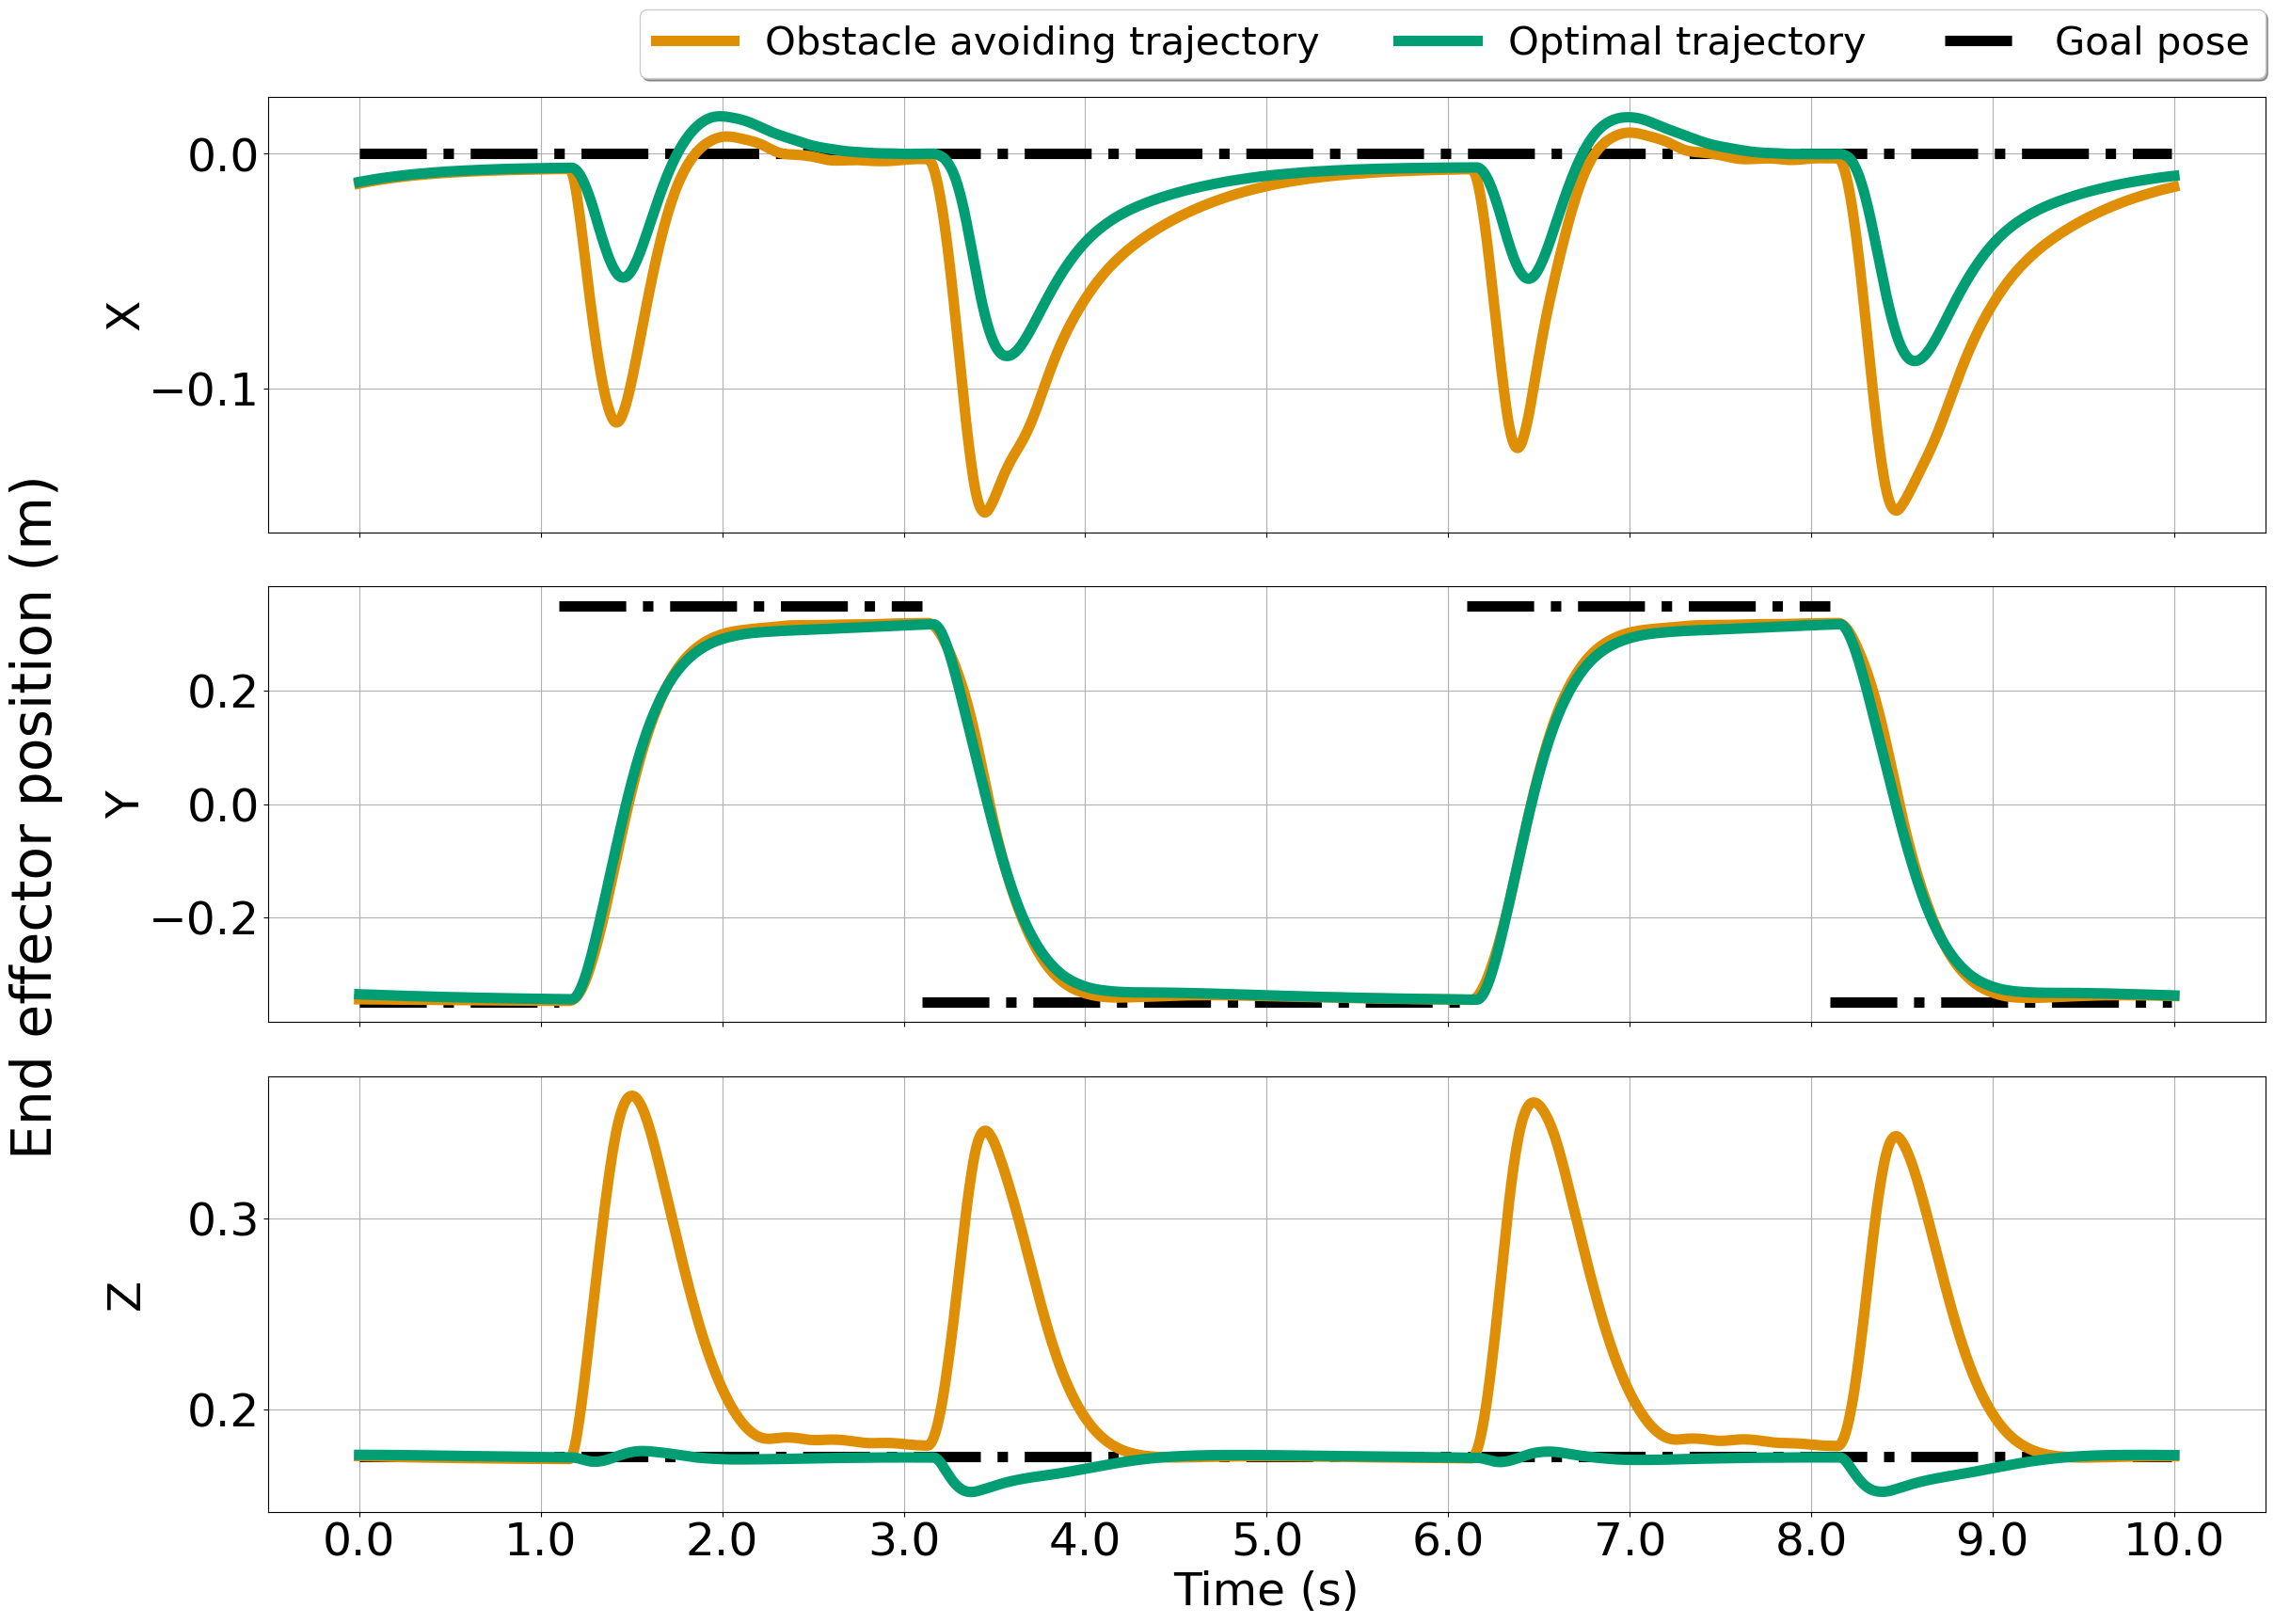

In [237]:
fig, axs = plt.subplots(nrows=3, sharex="col", figsize=(25, 18))

sns.set_palette("colorblind")

sns.lineplot(
    goal_df_cropped,
    x="Time",
    y=f"pose.position.x",
    ax=axs[0],
    label="Goal pose",
    color="#000000",
    linewidth=8.0,
    linestyle="-.",
)

minus = (1.0, -1.0)
pose_changes_appended = pose_changes.copy()
pose_changes_appended = np.insert(pose_changes_appended, 0, 0)
pose_changes_appended = np.append(pose_changes_appended, goal_df_cropped["Time"].tail(1))
for i in range(pose_changes_appended.shape[0] - 1):
    sns.lineplot(
        x=[pose_changes_appended[i], pose_changes_appended[i+1]],
        y=[-0.35 * minus[i%2], -0.35 * minus[i%2]],
        ax=axs[1],
        color="#000000",
        linewidth=8.0,
        linestyle="-.",
    )

sns.lineplot(
    goal_df_cropped,
    x="Time",
    y=f"pose.position.z",
    ax=axs[2],
    # label=name.upper(),
    color="#000000",
    linewidth=8.0,
    linestyle="-.",
)

for idx, name in enumerate(["x", "y", "z"]):
    sns.lineplot(
        pose_df_cropped,
        x="Time",
        y=name,
        ax=axs[idx],
        # label=name.upper(),
        linewidth=8.0,
        hue = "case",
        palette=["C1", "C2"]
    )
    axs[idx].set_ylabel(name.upper())
    axs[idx].get_yaxis().set_label_coords(-0.06, 0.5)



handles, labels = axs[0].get_legend_handles_labels()
order = [1, 2, 0]
axs[0].legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    fancybox=True,
    # framealpha=0.0,
    loc="upper right",
    bbox_to_anchor=(1.0, 1.2),
    shadow=True,
    borderaxespad=0,
    ncol=3,
)

axs[0].set_yticks([0.0, -0.1])

axs[1].get_legend().remove()
axs[2].get_legend().remove()

axs[1].set_xticks(np.arange(0,10.5,1.0))
axs[1].set_xticklabels(np.arange(0,10.5,1.0))


fig.supylabel("End effector position (m)")

axs[2].set_xlabel("Time (s)")

plt.tight_layout()
plt.savefig(
    "end_effector_pose.svg",
    format="svg",
    pad_inches=1.5,
    bbox_inches=Bbox([[0.5, 0], [26.5, 18]]),
)